# Import libraries

In [1]:
GLOBAL_RANDOM_SEED = 42
import sklearn as skl
skl.random.seed(GLOBAL_RANDOM_SEED)
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
import numpy as np
np.random.seed(GLOBAL_RANDOM_SEED)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
print( "sklearn version: " + str(skl.__version__) )

sklearn version: 1.0.2


# Prepare dataset from *.csv file

In [2]:
CSV_DATASET_PATH = r"/content/RT.csv"

In [3]:
#load dataset 
dataset_df = pd.read_csv(CSV_DATASET_PATH) 
# label = 1 (walking), label = 0 (not walking)
dataset_np = np.asarray(dataset_df, dtype= 'float64', order= 'C')
np.random.shuffle(dataset_np)
print (dataset_np)
# print(dataset_np)
X = dataset_np[:, :-1]
Y = dataset_np[:, -1]

[[0.57589286 0.05580357 0.47470238 ... 0.22172619 0.796875   0.        ]
 [0.49137931 0.11830357 0.52586207 ... 0.37643678 0.73883929 0.        ]
 [0.87723214 0.1082411  0.796875   ... 0.36383929 0.83995607 0.        ]
 ...
 [0.43627737 0.05580357 0.41615443 ... 0.26858623 0.72544643 1.        ]
 [0.39955357 0.07306514 0.52008929 ... 0.87276786 0.67853639 0.        ]
 [0.82312748 0.03794643 0.65928819 ... 0.47724454 0.75223214 1.        ]]


## Split dataset

In [4]:
# split dataset to traning, testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3, random_state= GLOBAL_RANDOM_SEED)
print ("the number of traning set is: " + str(y_train.shape[0]))
print ("the number of testing set is: " + str(y_test.shape[0]))

the number of traning set is: 150
the number of testing set is: 65


# Build SVM model

In [5]:
#Create a svm 
_C = 10
_GRAMMA = 1
_KERNEL = "rbf"

clf = svm.SVC(kernel= _KERNEL,  C= _C, gamma= _GRAMMA , random_state= GLOBAL_RANDOM_SEED)

# The effect of the parameters gamma and C of the Radial Basis Function (RBF)

In [6]:
class MidpointNormalize(Normalize): # utility function to move the midpoint of a colormap to be around the values of interest.
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma= gamma_range, C= C_range)
cv = StratifiedShuffleSplit(n_splits= 10, test_size= 0.3, random_state= GLOBAL_RANDOM_SEED)
grid = GridSearchCV(svm.SVC(kernel= "rbf", random_state= GLOBAL_RANDOM_SEED), param_grid= param_grid, cv= cv)
grid.fit(X, Y)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.89


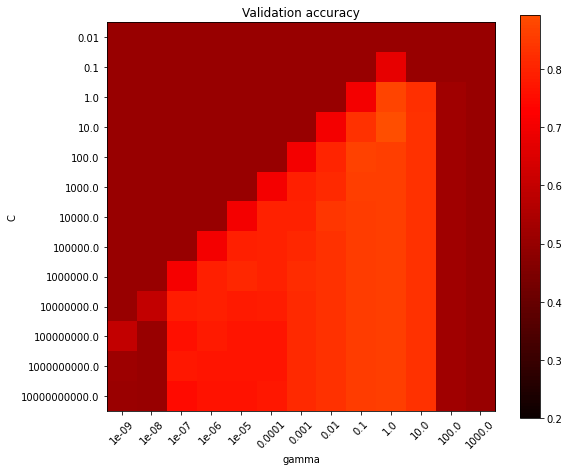

In [8]:
# draw heatmap of the validation accuracy as a function of gamma and C
plt.figure(figsize=(9, 7))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

# Perform cross-validation evaluating

In [12]:
scores = cross_val_score(clf, X, Y, cv= 10, scoring= 'accuracy') # k-fold = 10
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print ("scores: " + str(scores))

0.92 accuracy with a standard deviation of 0.05
scores: [0.86363636 0.90909091 0.90909091 1.         0.90909091 0.9047619
 1.         0.85714286 0.95238095 0.85714286]


In [10]:
scores

array([0.86363636, 0.90909091, 0.90909091, 1.        , 0.90909091,
       0.9047619 , 1.        , 0.85714286, 0.95238095, 0.85714286])

# Training the SVM model

In [11]:
#Train the model using the training sets
clf.fit(X_train, y_train)


# Evaluate the SVM model

## Predict on training set

In [20]:
#Predict the response for training set
y_train_pred = clf.predict(X_train)
# evaluating on the training set
print("Accuracy:", metrics.accuracy_score(y_train, y_train_pred)) 
print("Precision:", metrics.precision_score(y_train, y_train_pred)) # Model Precision: what percentage of positive tuples are labeled as such?
print("Recall:", metrics.recall_score(y_train, y_train_pred)) # Model Recall: what percentage of positive tuples are labelled as such?

Accuracy: 0.9866666666666667
Precision: 0.971830985915493
Recall: 1.0


## Predict on testing set


In [22]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)
# evaluating on the testing data
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred)) # Model Precision: what percentage of positive tuples are labeled as such?
print("Recall:", metrics.recall_score(y_test, y_pred)) # Model Recall: what percentage of positive tuples are labelled as such?

Accuracy: 0.9384615384615385
Precision: 0.9714285714285714
Recall: 0.918918918918919


# Draw charts

confusion matrix of evaluating on testing and training set respectively: 


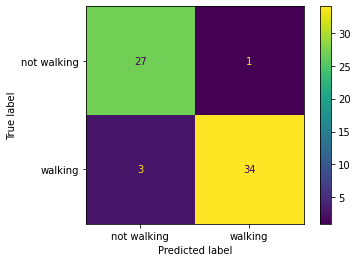

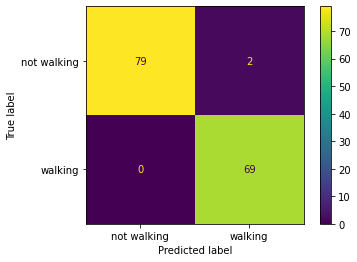

In [24]:
# plot confusion matrix
print ("confusion matrix of evaluating on testing and training set respectively: ")
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels= ["not walking", "walking"]) # 1 - walking, 0 - not walking
metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels= ["not walking", "walking"])

# Save and reload the pretrained SVM model

In [25]:
import pickle
FILE_NAME = r"/content/svm_action_recog.sav"
# save the pre-trained svm model
pickle.dump(clf, open(FILE_NAME, 'wb'))

In [26]:
# reload the pre-trained svm model
loaded_model = pickle.load(open(FILE_NAME, 'rb'))
loaded_result = loaded_model.score(X_test, y_test)
print(loaded_result)

0.9384615384615385


In [27]:
# Predict the response for test dataset
y_loaded_pred = loaded_model.predict(X_train)
print(y_loaded_pred)
# evaluating on the testing data
print("Accuracy:", metrics.accuracy_score(y_train, y_loaded_pred))
print("Precision:", metrics.precision_score(y_train, y_loaded_pred)) # Model Precision: what percentage of positive tuples are labeled as such?
print("Recall:", metrics.recall_score(y_train, y_loaded_pred)) # Model Recall: what percentage of positive tuples are labelled as such?

[0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0.]
Accuracy: 0.9866666666666667
Precision: 0.971830985915493
Recall: 1.0
